In [62]:
import os
import pandas as pd
import geopandas as gpd

# os.environ["USE_PYGEOS"] = os.environ.get("USE_PYGEOS", "0")
local_crs = 32636
# path to data
example_data_path = "./data"

In [63]:
# load aggregated info we have
aggregated_blocks = gpd.read_parquet(os.path.join(example_data_path, "data_getter_blocks.parquet"))
accessibility_matrix = pd.read_pickle(os.path.join(example_data_path, "data_getter_matrix.pickle"))

In [64]:
# load data required for service graphs creation
schools = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
recreational_areas = gpd.read_parquet(os.path.join(example_data_path, "recreational_areas.parquet")).rename_geometry('geometry')

hospitals = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson"))
pharmacies = gpd.read_file(os.path.join(example_data_path, "pharmacies.geojson"))
policlinics = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson"))

# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas,
            "hospitals": hospitals, "pharmacies": pharmacies, "policlinics": policlinics}

In [65]:
from masterplan_tools import CityModel

city_model = CityModel(
  blocks=aggregated_blocks, 
  accessibility_matrix=accessibility_matrix, 
  services=services
)

In [66]:
accessibility = 10
normative = 61

In [67]:
import math
import pandas as pd
import numpy as np

acc_df = city_model.accessibility_matrix.df
blocks = city_model.blocks.to_gdf()

In [68]:
blocks.loc[218, 'current_population'] += 100000

In [69]:
blocks['kindergartens_demand'] = (blocks['current_population']/1000*normative).apply(lambda x: math.ceil(x))
costs = pd.DataFrame(data=acc_df)
result = pd.DataFrame(index=costs.index, columns=costs.columns)
demand = blocks['kindergartens_demand']
capacity = (pd.DataFrame.from_dict(city_model.services_graph.nodes, orient='index').fillna(0).kindergartens_capacity).apply(lambda x: math.ceil(x))

In [70]:
#we dont have a lot of kindergartens tho, so demands are bigger than our capacities
print(demand.sum(), capacity.sum(), demand.sum()-capacity.sum())

18877 10459 8418


In [71]:
last = costs.iloc[:,-1].name + 1
costs.loc[:, last] = 0
costs = costs.to_numpy()
capacity[last] = demand.sum()-capacity.sum()

In [72]:
from pulp import *
import numpy as np
from itertools import product

N = len(demand)
M = len(capacity)
prob = LpProblem('Transportation', LpMinimize)
x = LpVariable.dicts('Route', product(range(N), range(M)), 0, None)
prob += lpSum(costs[n,m] * x[n,m] for n in range(N) for m in range(M))
for n in range(N):
  prob += lpSum(x[n,m] for m in range(M)) == demand[n]
for m in range(M):
  prob += lpSum(x[n,m] for n in range(N)) == capacity[m]
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/b3d6104ea6d44c34be8cd4c772ae5d80-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/b3d6104ea6d44c34be8cd4c772ae5d80-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2714 COLUMNS
At line 5503273 RHS
At line 5505983 BOUNDS
At line 5505984 ENDATA
Problem MODEL has 2709 rows, 1834670 columns and 3669340 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 160 (-2549) rows, 4191 (-1830479) columns and 8382 (-3660958) elements
Perturbing problem by 0.001% of 36.6 - largest nonzero change 0.00023973613 ( 0.0054976729%) - largest zero change 6.8138398e-05
0  Obj 0 Primal inf 37754 (160)
69  Obj 47404.219 Primal inf 8556.9999 (116)
139  Obj 56022.211 Primal inf 2130.2999 (88)
209  Obj 58679.354 Primal inf 10

1

In [73]:
for var in prob.variables():
  value = var.value()
  name = var.name.replace('(', '').replace(')', '').replace(',', '').split('_')
  a = int(name[1])
  b = int(name[2])
  if value > 0 and costs[a,b] <= accessibility and b != last : result.loc[a, b] = value

In [74]:
blocks['demand'] = demand
blocks['supplied']=result.sum(axis=1)
blocks['provision'] = blocks['supplied'] / blocks['demand']

<Axes: >

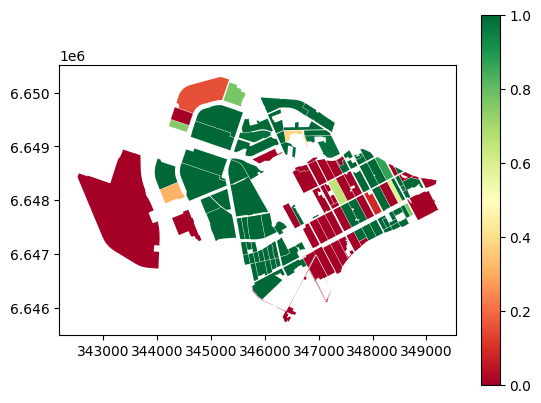

In [75]:
blocks.plot(column='provision', legend=True,cmap='RdYlGn')